In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

df_als = pd.read_csv("nbaallstargames.csv") # All-Star data
df_stat = pd.read_csv("correct_data.csv", sep=";") # Season Statistics

# Delete seasons older than 1980
df_stat = df_stat[df_stat["Year"] >= 1980]
df_stat = df_stat[df_stat["MP"] >= 300]

# Delete unnecessary statistics and customize the statistics in a per game fashion
deletedColumns = ["Column1", "Tm", "GS", "PER", "FTr", "ORB%", "DRB%", "TRB%", "AST%", "STL%", "BLK%", "TOV%", "blanl","OWS", "DWS","WS", "WS/48", "blank2", "OBPM", "DBPM","BPM", "VORP", "FG", "FGA", "3P", "3PA", "2P", "2PA", "eFG%", "FT", "FTA", "ORB", "DRB"]
df_stat = df_stat.drop(columns=deletedColumns)
df_stat = df_stat.assign(MinutesPlayed=df_stat["MP"].astype(int))
df_stat["PointsPerGame"] = (df_stat["PTS"] / df_stat["G"]).round(1)
df_stat["Rebounds"] = (df_stat["TRB"] / df_stat["G"]).round(1)
df_stat["Assists"] = (df_stat["AST"] / df_stat["G"]).round(1)
df_stat["Steals"] = (df_stat["STL"] / df_stat["G"]).round(1)
df_stat["Blocks"] = (df_stat["BLK"] / df_stat["G"]).round(1)
df_stat["Turnovers"] = (df_stat["TOV"] / df_stat["G"]).round(1)
df_stat["PersonalFouls"] = (df_stat["PF"] / df_stat["G"]).round(1)
df_stat = df_stat.assign(Age=df_stat["Age"].astype(int)) 
df_stat = df_stat.drop(columns=["G", "PTS", "TRB", "AST", "STL", "BLK", "TOV", "PF", "MP"])

# Reassign the player and year stat as one singular column for the Season Statistics and moving it the first column
df_stat = df_stat.assign(Season = df_stat["Player"].str.replace("*", '', regex=False).astype(str) + "-" + df_stat["Year"].astype(int).astype(str))
df_stat = df_stat.drop(columns=["Year", "Player"])
player_column = df_stat.pop("Season")
df_stat.insert(0, "Season", player_column)

# Reassign the player and year stat as one singular column for the All-Atar data and moving it the first column
df_als = df_als.assign(Season = df_als["Player"].astype(str) + "-" + df_als["Year"].astype(int).astype(str))
df_als = df_als.drop(columns=["Player", "Year"])
player_column = df_als.pop("Season")
df_als.insert(0, "Season", player_column)

# Merge the two dataframes based on Season and set Role as the new column for
df_merged = df_stat.merge(df_als[["Season", "Role"]], on="Season", how="left")

# Mapping the "Role" to numerical values
role_mapping = {
    "Starter": 2,
    "Reserve": 1,
    "DNP": 1  # DNP should be treated the same as "Reserve"
}

# Map the correct numbers on to the Seasons. Give 0 to all of the players not mentioned in the All-Star Data
df_merged["AllStarStatus"] = df_merged["Role"].map(role_mapping).fillna(0).astype(int)

# Drop the column Role because it is now described by 0, 1 or 2
df_merged = df_merged.drop(columns=["Role"])

# Shuffling and splitting the data into train, validation and test categories with a 60:20:20 split
df_merged = df_merged.sample(frac=1, random_state=1).reset_index(drop=True)
train_size = int(0.6 * len(df_merged))
val_size = int(0.2 * len(df_merged))

train_data = df_merged[:train_size]  # First 60%
val_data = df_merged[train_size:(train_size + val_size)]  # Next 20%
test_data = df_merged[(train_size + val_size):]  # Remaining 20%

print("Data processed successfully!")

Data processed successfully!


In [10]:
import KnnModel
import RFModel
import PearsonCorrelation

knnModel = KnnModel.BasketballModel()
knnModel.train_and_validate_model(train_data, val_data)
print("KNN trained successfully!")
knnModel.test_model(test_data)
print("KNN tested successfully!")

------------------------------
KNN MODEL TRAINING RESULTS
Validation Accuracy: 0.9396

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2663
           1       0.39      0.18      0.25       119
           2       0.49      0.35      0.41        80

    accuracy                           0.94      2862
   macro avg       0.61      0.51      0.54      2862
weighted avg       0.92      0.94      0.93      2862

KNN trained successfully!
------------------------------
KNN MODEL TEST RESULTS
Test Accuracy: 0.9445

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2666
           1       0.45      0.20      0.28       123
           2       0.58      0.49      0.53        74

    accuracy                           0.94      2863
   macro avg       0.66      0.56      0.60      2863
weighted avg       0.93      

In [11]:
rfModel = RFModel.BasketballModel()
rfModel.train_and_validate_model(train_data, val_data)
print("Random Forest trained successfully!")
rfModel.test_model(test_data)
print("Random Forest tested successfully!")

------------------------------
RANDOM FOREST MODEL TRAINING RESULTS
Validation Accuracy: 0.9458

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2663
           1       0.46      0.26      0.33       119
           2       0.62      0.44      0.51        80

    accuracy                           0.95      2862
   macro avg       0.68      0.56      0.61      2862
weighted avg       0.93      0.95      0.94      2862

Random Forest trained successfully!
------------------------------
RANDOM FOREST MODEL TEST RESULTS
Test Accuracy: 0.9427

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2666
           1       0.39      0.18      0.24       123
           2       0.64      0.51      0.57        74

    accuracy                           0.94      2863
   macro avg       0.66      0.56      0.60      2863

In [12]:
pearsonModel = PearsonCorrelation.Pearson()
pearsonModel.calculate_coefficients(train_data, val_data)
print("\nPearson Coefficients calculated successfully")
print("\n All models and coefficients trained, validated, and saved.".upper())

------------------------------

Pearson Correlation Coefficients for Features:
      Feature  Pearson Coefficient
PointsPerGame             0.515444
    Turnovers             0.402499
         USG%             0.382286
MinutesPlayed             0.370833
     Rebounds             0.321298
       Steals             0.311090
      Assists             0.290774
       Blocks             0.220484
          TS%             0.209860

Pearson Coefficients calculated successfully

 ALL MODELS AND COEFFICIENTS TRAINED, VALIDATED, AND SAVED.


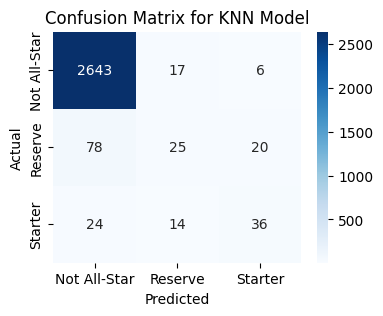

In [13]:
knnModel.plot_confusion_matrix(test_data)

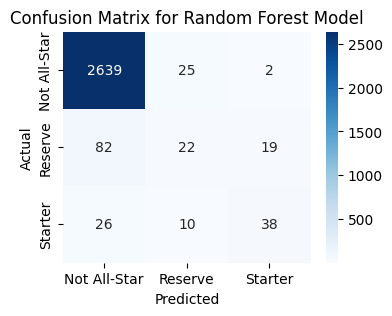

In [14]:
rfModel.plot_confusion_matrix(test_data)

c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScal

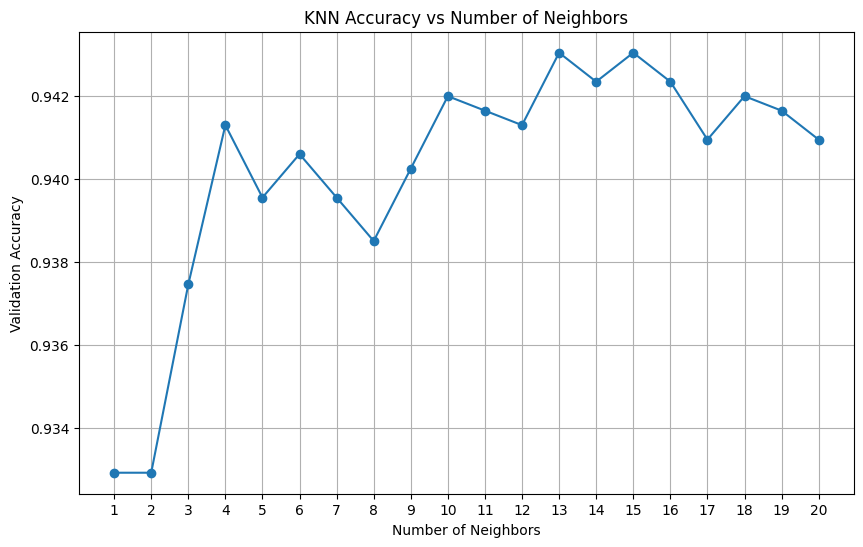

In [15]:
# Plotting how the amount of neighbors affects accuracy
knnModel.plot_accuracy_vs_neighbors(train_data, val_data, max_neighbors=20)

c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScal

TypeError: '<' not supported between instances of 'int' and 'NoneType'

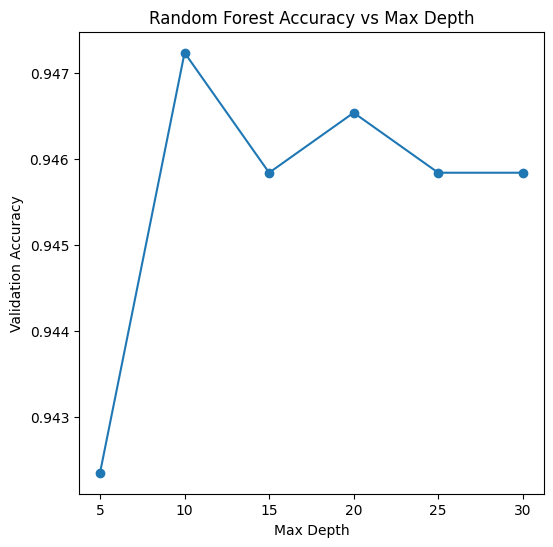

In [16]:
# Plotting how the amount of max depth affects accuracy

max_depths = [None, 5, 10, 15, 20, 25, 30]
rfModel.plot_accuracy_vs_max_depth(train_data, val_data, max_depths)

c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\silvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScal

TypeError: '<' not supported between instances of 'int' and 'NoneType'

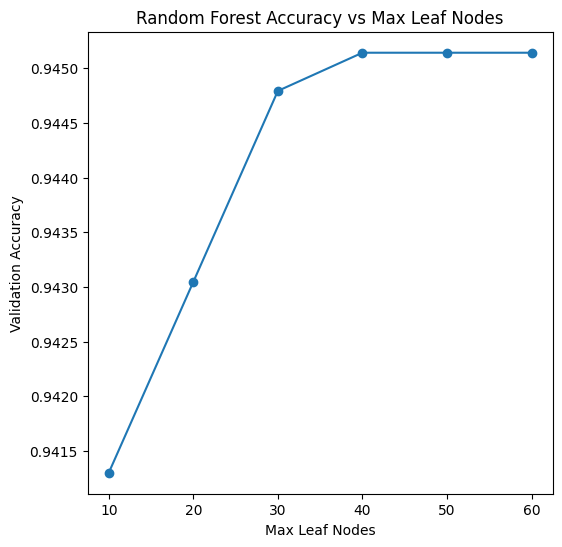

In [17]:
# Plotting how the amount of max leaf nodes affects accuracy

max_leaf_nodes = [None, 10, 20, 30, 40, 50, 60]
rfModel.plot_accuracy_vs_max_leaf_nodes(train_data, val_data, max_leaf_nodes)